In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from imutils import paths
import cv2
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
import librosa
import librosa.display
import pandas as pd

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Urban Sounds/spectrograms/'
# Veri seti dizinindeki tüm görüntü dosyalarını yükle
# Görüntü dizinlerini oku
imagePaths = list(paths.list_images(path))
data = []
labels = []

In [ ]:
def preprocess_img(img):
    # apply opencv preprocessing
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img,  (32, 32)) 
    img = np.asarray(img, dtype=np.float)
    img=(img-np.min(img))/(np.max(img)-np.min(img))
    return img

In [ ]:
i=0
for imagePath in imagePaths:
    # spectrograms dosya ismi ise görüntüyü okuyup data içerisine ekle
    img_type = imagePaths[i].split('\\')[-1].split('-')[1]
    imagePath = imagePaths[i]
    # Dosya isminden etiketi belirle
    if img_type=='0':
        label="air_conditioner"
    elif img_type=='1':
        label="car_horn"
    elif img_type=='2':
        label="children_playing"
    elif img_type=='3':
        label="dog_bark"
    elif img_type=='4':
        label="drilling"
    elif img_type=='5':
        label="engine_idling"
    elif img_type=='6':
        label="gun_shot"
    elif img_type=='7':
        label="jackhammer"
    elif img_type=='8':
        label="siren"
    elif img_type=='9':
        label="street_music"    
    # Görüntüyü oku ve önişle
    img = cv2.imread(imagePath)
    image = preprocess_img(img)       
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
    i+=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [ ]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [ ]:
data.shape

(8732, 32, 32)

In [ ]:
labels.shape

(8732, 10)

In [ ]:
#burada data verimiz (8732, 32, 32) boyutunda büyük bir veri olduğu için bu veriyi kaydediyoruz. 
np.save("/content/drive/MyDrive/Colab Notebooks/Urban Sounds/data", data)
np.save("/content/drive/MyDrive/Colab Notebooks/Urban Sounds/labels", labels)

In [ ]:
#burada kaydettiğimiz datayı ve etikleri açıyoruz.
data = np.load("/content/drive/MyDrive/Colab Notebooks/Urban Sounds/data.npy")
labels = np.load("/content/drive/MyDrive/Colab Notebooks/Urban Sounds/labels.npy")

In [ ]:
data.shape

(8732, 32, 32)

In [ ]:
labels.shape

(8732, 10)

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25,random_state=42)

In [ ]:
from keras.layers import Dense, Dropout, Activation, Flatten

In [ ]:
model = Sequential()
# 32 adet 3x3 boyutunda filtereler oluşturulur ve modele eklenir.
# "Padding" fotoğrafa çervçeve ekler ve çıkış boyutunun giriş boyutuna eşit olması sağlanır.
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(32, 32, 1)))
# ReLu aktivasyon fonksiyonumuzu ekliyoruz:
model.add(Activation('relu'))
# 32 adet 3x3 boyutunda filterelerden oluşan katmanımızı modelimize ekliyoruz:
model.add(Conv2D(32, (3, 3)))
# ReLu aktivasyon fonksiyonumuzu ekliyoruz:
model.add(Activation('relu'))
# 2x2 boyutunda çerçeveden oluşan MaxPooling katmanımızı ekliyoruz:
model.add(MaxPooling2D(pool_size=(2, 2)))
# Rastgele olacak şekilde nöronların %25'ini kapatıyoruz: (Eğitim sırasındaki ezberlemeyi önlemek için.)
model.add(Dropout(0.25))

# 64 adet 3x3 boyutunda filterelerden oluşan katmanımızı modelimize ekliyoruz:
model.add(Conv2D(64, (3, 3), padding='same'))
# ReLu aktivasyon fonksiyonumuzu ekliyoruz:
model.add(Activation('relu'))
# 64 adet 3x3 boyutunda filterelerden oluşan katmanımızı modelimize ekliyoruz:
model.add(Conv2D(64, (3, 3)))
# ReLu aktivasyon fonksiyonumuzu ekliyoruz:
model.add(Activation('relu'))
# 2x2 boyutunda çerçeveden oluşan MaxPooling katmanımızı ekliyoruz:
model.add(MaxPooling2D(pool_size=(2, 2)))
# Rastgele olacak şekilde nöronların %25'ini kapatıyoruz:
model.add(Dropout(0.25))

# 2 boyutlu görsellerimizi 1 boyutlu vektöre çeviriyoruz:
model.add(Flatten())
# 512 nöronumuzu modelimize ekliyoruz:
model.add(Dense(512))
# ReLu aktivasyon fonksiyonumuzu ekliyoruz:
model.add(Activation('relu'))
# Rastgele olacak şekilde nöronların %50'sini kapatıyoruz:
model.add(Dropout(0.5))
# 10 sınıfımızı temsil edecek 10 nöronumuzu modelimize ekliyoruz:
model.add(Dense(10)) # num_classes = 10
# Sınıfların olasılıklarını hesaplamak için "Softmax" fonksiyonumuzu ekliyoruz:
model.add(Activation('softmax'))

In [ ]:
from tensorflow import keras
from keras import optimizers
opt=keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
model.compile(optimizer=opt,loss="categorical_crossentropy",metrics=['categorical_accuracy'])

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/Urban Sounds/urban_sound2.h5')

In [ ]:
hist = model.fit(trainX,trainY,batch_size=32,epochs=60,validation_split=0.2)
model.save('/content/drive/MyDrive/Colab Notebooks/Urban Sounds/urban_sound2.h5')

Epoch 1/60
164/164 [==============================] - 7s 32ms/step - loss: 2.0495 - categorical_accuracy: 0.2306 - val_loss: 1.8130 - val_categorical_accuracy: 0.3481
Epoch 2/60
164/164 [==============================] - 5s 30ms/step - loss: 1.7726 - categorical_accuracy: 0.3400 - val_loss: 1.6052 - val_categorical_accuracy: 0.4191
Epoch 3/60
164/164 [==============================] - 5s 31ms/step - loss: 1.5898 - categorical_accuracy: 0.4131 - val_loss: 1.4948 - val_categorical_accuracy: 0.4679
Epoch 4/60
164/164 [==============================] - 5s 32ms/step - loss: 1.4976 - categorical_accuracy: 0.4558 - val_loss: 1.4643 - val_categorical_accuracy: 0.4870
Epoch 5/60
164/164 [==============================] - 5s 30ms/step - loss: 1.4302 - categorical_accuracy: 0.4915 - val_loss: 1.3318 - val_categorical_accuracy: 0.5656
Epoch 6/60
164/164 [==============================] - 5s 31ms/step - loss: 1.3648 - categorical_accuracy: 0.5209 - val_loss: 1.2833 - val_categorical_accuracy: 0.574

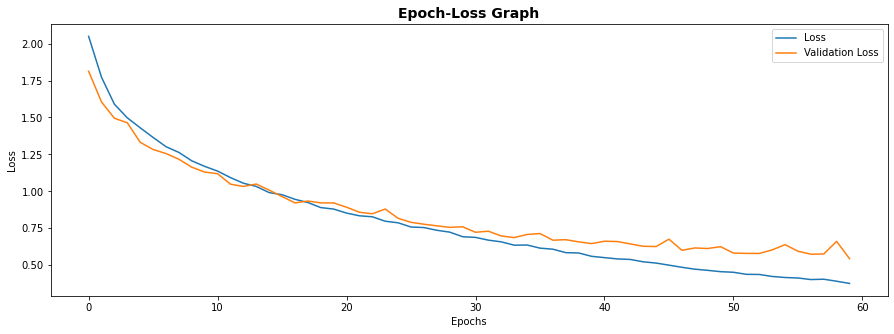

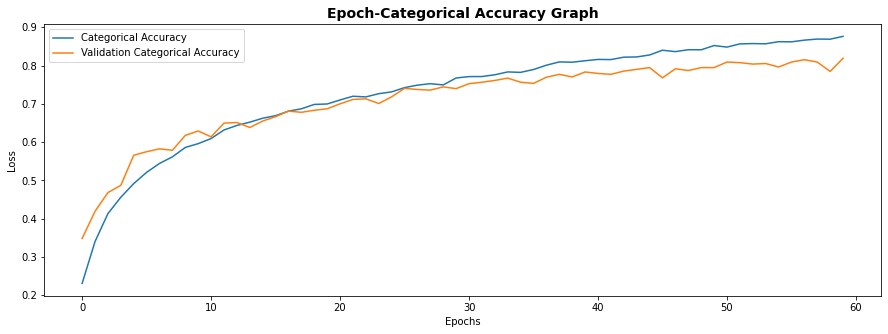

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.title('Epoch-Loss Graph', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(0, 210, 10))

plt.plot(hist.epoch, hist.history['loss'])
plt.plot(hist.epoch, hist.history['val_loss'])
plt.legend(['Loss', 'Validation Loss'])
plt.show()

plt.figure(figsize=(15, 5))
plt.title('Epoch-Categorical Accuracy Graph', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(0, 210, 10))

plt.plot(hist.epoch, hist.history['categorical_accuracy'])
plt.plot(hist.epoch, hist.history['val_categorical_accuracy'])
plt.legend(['Categorical Accuracy', 'Validation Categorical Accuracy'])
plt.show()

In [ ]:
eval_result = model.evaluate(testX, testY)

69/69 [==============================] - 0s 7ms/step - loss: 0.5570 - categorical_accuracy: 0.8213


In [ ]:
eval_result = model.evaluate(testX, testY)

for i in range(len(eval_result)):
    print(f'{model.metrics_names[i]}: {eval_result[i]}')

69/69 [==============================] - 1s 7ms/step - loss: 0.5570 - categorical_accuracy: 0.8213
loss: 0.5570483803749084
categorical_accuracy: 0.8213467597961426


In [ ]:
resim=testX[200].reshape((1, 32, 32, 1))

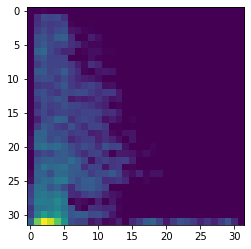

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(testX[200])
plt.show()

In [ ]:
predict_result = model.predict(resim)

In [ ]:
result_index = np.argmax(predict_result[0])

In [ ]:
etiket = ["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer","siren","street_music"]

In [ ]:
tahmin = etiket[result_index]
print(tahmin)

gun_shot


In [ ]:
def create_spectogram(sound):
    y,sr = librosa.load(sound)
    spec = librosa.feature.melspectrogram(y=y,sr=sr)
    spec_conv = librosa.amplitude_to_db(spec,ref = np.max)
    return spec_conv,sr

In [ ]:
sound = '/content/drive/MyDrive/Colab Notebooks/Urban Sounds/sesler/14114-4-0-2.wav'
spectogram,sr = create_spectogram(sound)

In [ ]:
from IPython.display import Audio
wn = Audio(sound, autoplay=True)
display(wn)

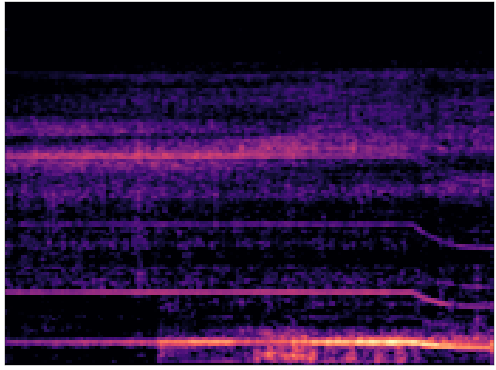

In [ ]:
my_dpi = 32
plt.figure(figsize=(500/my_dpi, 374/my_dpi), dpi=my_dpi)
librosa.display.specshow(spectogram,sr=sr, fmax=8000)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Urban Sounds/resimler/out.png')

In [ ]:
resim ='/content/drive/MyDrive/Colab Notebooks/Urban Sounds/resimler/'
imagePaths_test = list(paths.list_images(resim))

img = cv2.imread(imagePaths_test[0])
image = preprocess_img(img) 

resim=image.reshape((1, 32, 32, 1))
predict_result = model.predict(resim)

result_index = np.argmax(predict_result[0])
etiket = ["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer","siren","street_music"]
tahmin = etiket[result_index]
print("TAHMİN:"+tahmin)

TAHMİN:engine_idling


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
